<a href="https://colab.research.google.com/github/cotton-ahn/TUM_20WS_Intro2Deep/blob/main/Lecture4_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from tensorflow import summary
import tensorflow as tf

In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.7.0+cu101


### Import your drive's contents!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Let's load the CIFAR10 dataset


In [ ]:
data_path = './cifar10'
model_dir = './drive/MyDrive/Codes/models'
batch_size = 64
train_dataset = torchvision.datasets.CIFAR10(data_path, True, transform= torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10(data_path, False, transform= torchvision.transforms.ToTensor(), download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Choose your device - use GPU or not?

In [ ]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Try to sample out one data point from dataloader

In [ ]:
sample = next(iter(train_dataloader))
# sample = test_dataset[1]
print(sample[0].shape)
print(sample[1])

torch.Size([64, 3, 32, 32])
tensor([6, 4, 7, 9, 9, 2, 3, 8, 2, 3, 9, 8, 8, 1, 9, 3, 5, 1, 1, 4, 0, 6, 1, 0,
        2, 3, 9, 6, 6, 3, 6, 0, 5, 7, 9, 1, 5, 2, 4, 8, 7, 7, 4, 7, 0, 9, 0, 6,
        7, 6, 9, 7, 4, 2, 7, 2, 6, 6, 4, 4, 6, 4, 6, 4])


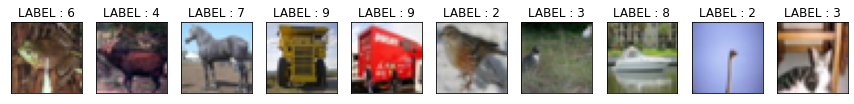

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(15, 4))
for plot_idx in range(10):
    ax[plot_idx].imshow(sample[0][plot_idx].permute(1, 2, 0))
    ax[plot_idx].set_title('LABEL : {}'.format(sample[1][plot_idx]))
    ax[plot_idx].set_xticks([])
    ax[plot_idx].set_yticks([])
plt.show()

### Define the Multiple Layer Perceptrons

In [ ]:
class CNNs(nn.Module):
    def __init__(self, channels=[32, 64, 128], img_size = 32, dim_output=10):
        super(CNNs, self).__init__()
        
        self.channels = channels
        self.conv1 = nn.Conv2d(3, self.channels[0], kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.channels[0], self.channels[1], kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.channels[1], self.channels[2], kernel_size=3, stride=1, padding=1)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.activation = nn.ReLU()
        self.fc1 = nn.Linear(channels[2]*(img_size//8)**2, channels[2])
        self.fc2 = nn.Linear(channels[2], dim_output)
        

    def forward(self, img):
        batch_size = img.shape[0]
        out = self.activation(self.max_pool(self.conv1(img)))
        out = self.activation(self.max_pool(self.conv2(out)))
        out = self.activation(self.max_pool(self.conv3(out)))
        out = self.fc2(self.fc1(out.view(batch_size, -1)))
        
        return out

### Define the Model

In [ ]:
model = CNNs()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

print(model)

CNNs(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Define functions for train/test

In [ ]:
def train(model, optimizer, sample):
    model.train()

    criterion = nn.CrossEntropyLoss()

    optimizer.zero_grad()

    img = sample[0].float().to(device)
    label = sample[1].long().to(device) 
    
    pred = model(img)

    num_correct = sum(torch.argmax(pred, dim=1) == label)
    
    pred_loss = criterion(pred, label)
    
    # Try to add the regularization loss!

    pred_loss.backward()
       
    optimizer.step()

    return pred_loss.item(), num_correct.item()

In [ ]:
def test(model, sample):
    model.eval()

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        img = sample[0].float().to(device)
        label = sample[1].long().to(device) 

        pred = model(img)
        pred_loss = criterion(pred, label)

        num_correct = sum(torch.argmax(pred, dim=1) == label)

    return pred_loss.item(), num_correct.item()

### Prepare the Tensorboard

In [ ]:
train_log_dir = './runs/train_normal'
train_summary_writer = summary.create_file_writer(train_log_dir)
test_log_dir = './runs/test_normal'
test_summary_writer = summary.create_file_writer(test_log_dir)

In [ ]:
%tensorboard --logdir runs

### Run Training

In [ ]:
max_epoch = 200
tmp_path = './checkpoint.pth'

for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    # Load the saved MODEL AND OPTIMIZER after evaluation.
    if epoch > 0:
        checkpoint = torch.load(tmp_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # how about learning rate scheduler?

    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        curr_loss, num_correct = train(model, optimizer, sample)
        train_loss += curr_loss / len(train_dataloader)
        train_accu += num_correct / len(train_dataset)

    # Write the current loss and accuracy to the Tensorboard
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step=epoch)                
        tf.summary.scalar('accuracy', train_accu, step=epoch)                

    # save the model and optimizer's information before the evaulation
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        # how about learning rate scheduler?
    }
    torch.save(checkpoint, tmp_path)
    torch.save(model.state_dict(), os.path.join(model_dir, 'recent.pth'))
    
    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    for idx, sample in enumerate(test_dataloader):
        curr_loss, num_correct = test(model, sample)
        test_loss += curr_loss / len(test_dataloader)
        test_accu += num_correct / len(test_dataloader)

    # Write the current loss and accuracy to the Tensorboard
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss, step=epoch)
        tf.summary.scalar('accuracy', test_accu, step=epoch) 

KeyboardInterrupt: ignored